In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import os
import csv

%matplotlib inline

from sklearn.metrics.pairwise import linear_kernel

from sklearn import svm


import re

import nltk
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package stopwords to /home/fakher/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
solution_file = open("./processed_data/FinalSolutions-multilabel-ant.txt")
solutions = []
for line in solution_file:
    line = line.lower()
    line = line.replace("nan", "")
    line = line.replace("\n", "")
    solutions.append(str(line))

In [3]:
import re
solution_str = []
objectives = []
for dd in solutions:
    num_str = dd[-16:]
    int_numbers = [int(nn) for nn in (re.findall('\d+', num_str ))]
    strs = dd[:-16]
    if len(int_numbers)==6:
        solution_str.append(strs)
        objectives.append(np.array(int_numbers))
    else:
        continue

In [4]:
solution_str = [solution_str[i].replace(".", "") for i in range(len(solution_str))]
objectives = np.array(objectives)

In [5]:
objectives.shape, len(solution_str)

((6579, 6), 6579)

In [6]:
#Convert the data into a data frame:
df = pd.DataFrame(solution_str)
df.columns = ["solution"]

ob_df = pd.DataFrame(objectives)
ob_df.columns = ["Effectiveness", "Extendibility", "Flexibility", "Functionality", "Reusability", "Understandability"]

df['Effectiveness']= ob_df['Effectiveness']
df['Extendibility']= ob_df['Extendibility']
df['Flexibility']= ob_df['Flexibility']
df['Functionality']= ob_df['Functionality']
df['Reusability']= ob_df['Reusability']
df['Understandability']= ob_df['Understandability']

In [7]:
df.head()

,solution,Effectiveness,Extendibility,Flexibility,Functionality,Reusability,Understandability
0,extractsubclass orgapachetoolsanthelperproject...,1,0,1,1,0,1
1,extractsubclass orgapachetoolsanthelperproject...,1,0,1,1,0,1
2,pushdownmethod orgapachetoolsantfiltersbasepar...,0,0,1,1,0,1
3,pushdownmethod orgapachetoolsantprojecthelper ...,1,0,1,1,0,0
4,increasemethodsecurity orgapachetoolsanttaskde...,1,1,1,1,0,1


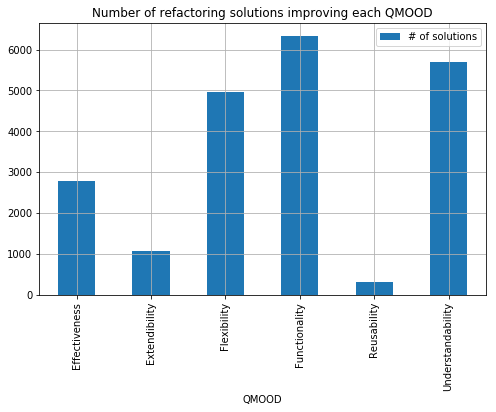

In [8]:
df_toxic = ob_df
counts = []
categories = list(df_toxic.columns.values)
for i in categories:
    counts.append((i, df_toxic[i].sum()))
df_stats = pd.DataFrame(counts, columns=['QMOOD', '# of solutions'])

df_stats.plot(x='QMOOD', y='# of solutions', kind='bar', legend=True, grid=True, figsize=(8, 5))
plt.title("Number of refactoring solutions improving each QMOOD")
plt.savefig('./figs/ant/#-sol-per-qmood.png')

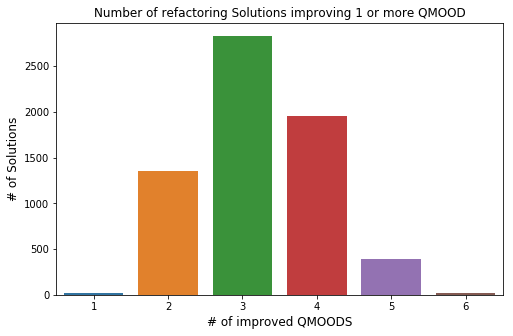

In [9]:
rowsums = ob_df.sum(axis=1)
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Number of refactoring Solutions improving 1 or more QMOOD")
plt.ylabel('# of Solutions', fontsize=12)
plt.xlabel('# of improved QMOODS', fontsize=12)
plt.savefig('./figs/ant/#-solutions-improving-=>1-qmood.png')

In [10]:
def f_importances(coef, names, category):
    for i in range(len(coef)):
        imp = coef[i]
        print("class:",i)
        imp,names = zip(*sorted(zip(imp,names)))
        plt.barh(range(len(names[-20:])), imp[-20:], align='center')
        plt.yticks(range(len(names[-20:])), names[-20:])
        # save figure 
        plt.savefig(f'./figs/ant/top-20-important-refops+locations-{category}.png')
        plt.show()

In [11]:
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)

(5723,)
(856,)
... Processing Effectiveness
Test accuracy is 0.8271028037383178
class: 0


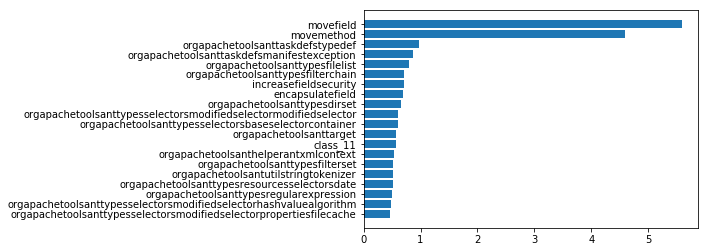

... Processing Extendibility
Test accuracy is 0.866822429906542
class: 0


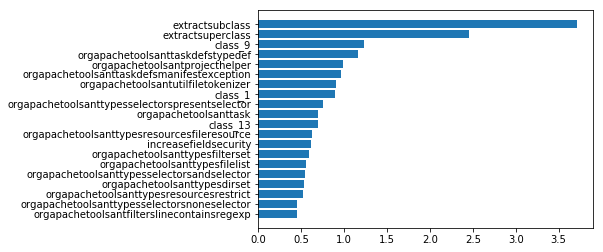

... Processing Flexibility
Test accuracy is 0.8481308411214953
class: 0


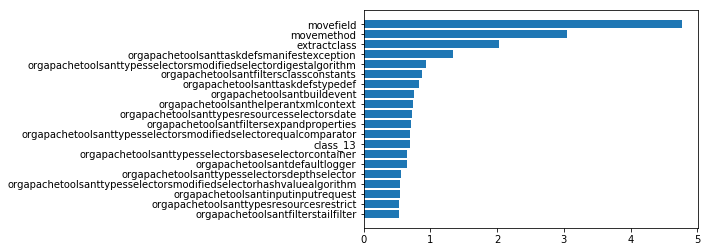

... Processing Functionality
Test accuracy is 0.9649532710280374
class: 0


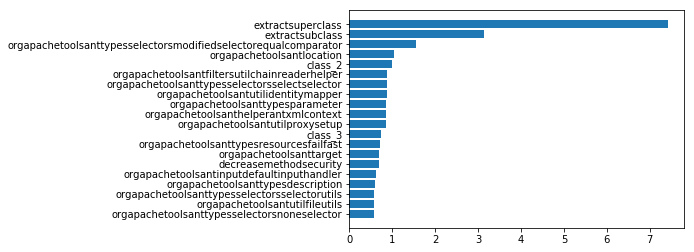

... Processing Reusability
Test accuracy is 0.955607476635514
class: 0


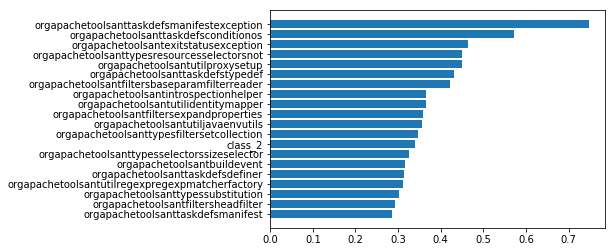

... Processing Understandability
Test accuracy is 0.889018691588785
class: 0


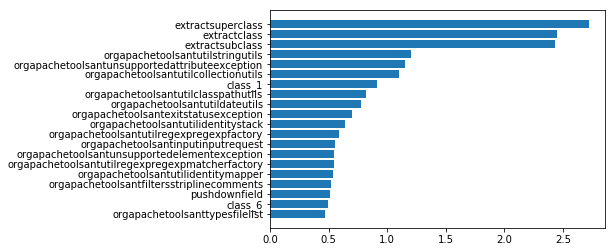

In [12]:
#Experiment 1: tfidf features for original solutions

train_1, test_1 = train_test_split(df, random_state=42, test_size=0.13, shuffle=True)

X_train_1 = train_1.solution
X_test_1 = test_1.solution
print(X_train_1.shape)
print(X_test_1.shape)



SVC_pipeline_original = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])

# writing to csv file 
with open(f'./feature_ranking/important_features-ant.csv', 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    for category in categories:
        print('... Processing {}'.format(category))
        # train the model using X_dtm & y
        SVC_pipeline_original.fit(X_train_1, train_1[category])
        # compute the testing accuracy
        prediction = SVC_pipeline_original.predict(X_test_1)
        print('Test accuracy is {}'.format(accuracy_score(test_1[category], prediction)))
        #SVC_pipeline.steps[1][1].coef_
        f_importances(SVC_pipeline_original.steps[1][1].coef_, SVC_pipeline_original.steps[0][1].get_feature_names(), category)
        #SVC_pipeline.coef_
        tmp = sorted(filter(lambda x: x[0] > 0, zip(SVC_pipeline_original.steps[1][1].coef_[0], SVC_pipeline_original.steps[0][1].get_feature_names())), reverse=True)
        row = filter(lambda x: x[1][:5] != 'class', tmp)
        csvwriter.writerow([f'{category}']+[imp[1] for imp in row])
        